# Random Forest

In [28]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from itertools import product
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load data
X_train_input = np.load("Data/X_train.npy")  # shape (700, 6)
Y_train_input = np.load("Data/Y_train.npy")  # shape (700,)

# Random train/test split (200 for test, 500 for training and cross-validation)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train_input, Y_train_input, test_size=200, random_state=19, shuffle=True
)


In [30]:
# Hyperparameter grids
n_estimators_list = [100, 200, 250, 300]
max_depth_list = [None, 10, 20, 30]
min_samples_split_list = [2, 5, 10]

# K-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=19)

best_r2 = -np.inf
best_params = None
results = []

In [ ]:
param_grid = list(product(
    n_estimators_list, 
    max_depth_list, 
    min_samples_split_list,
    ))

for n_estimators, max_depth, min_samples_split, in tqdm(param_grid, desc="Hyperparameter search"):
    
    r2_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = Y_train[train_idx], Y_train[val_idx]
        
        # Train model
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=19,
            n_jobs=-1
        )
        model.fit(X_tr, y_tr)
        
        # Predict on validation fold
        y_val_pred = model.predict(X_val)
        r2_scores.append(r2_score(y_val, y_val_pred))
    
    mean_r2 = np.mean(r2_scores)
    results.append({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'mean_r2': mean_r2
    })
    
    if mean_r2 > best_r2:
        best_r2 = mean_r2
        best_params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
        }

print("Best Cross Validation R2:", best_r2)
print("Best Hyperparameters:", best_params)

Hyperparameter search: 100%|██████████| 48/48 [01:27<00:00,  1.83s/it]


In [32]:
final_model = RandomForestRegressor(**best_params, random_state=19, n_jobs=-1)
final_model.fit(X_train, Y_train)

y_test_pred = final_model.predict(X_test)
test_r2 = r2_score(Y_test, y_test_pred)

print("R² on held-out 200 test samples:", test_r2)

R² on held-out 200 test samples: 0.9591939699999416


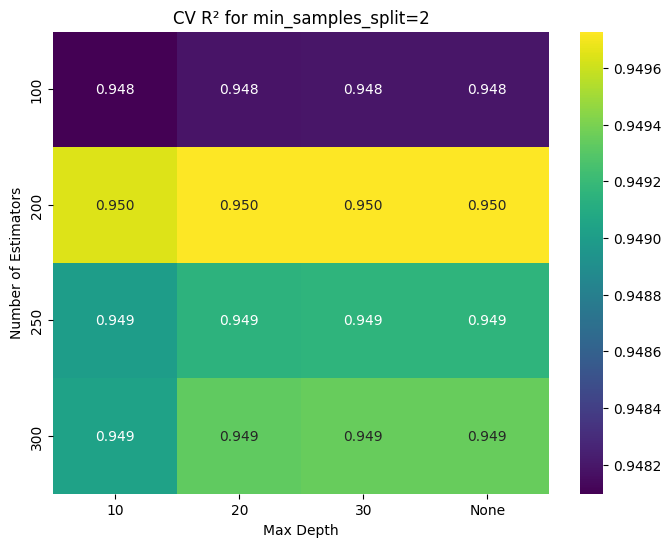

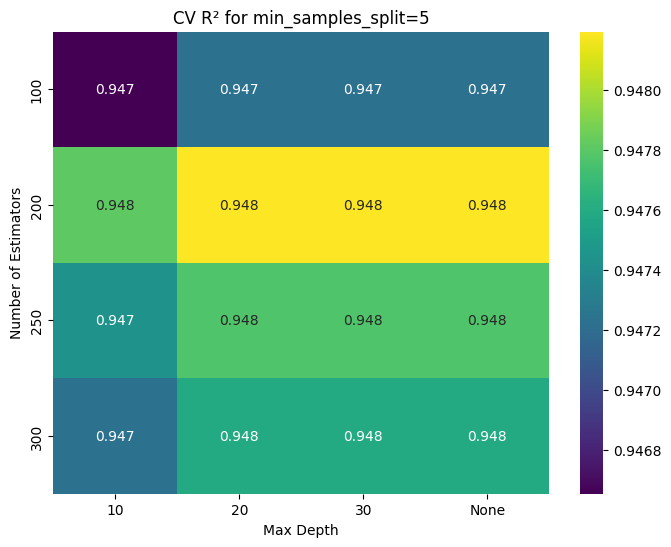

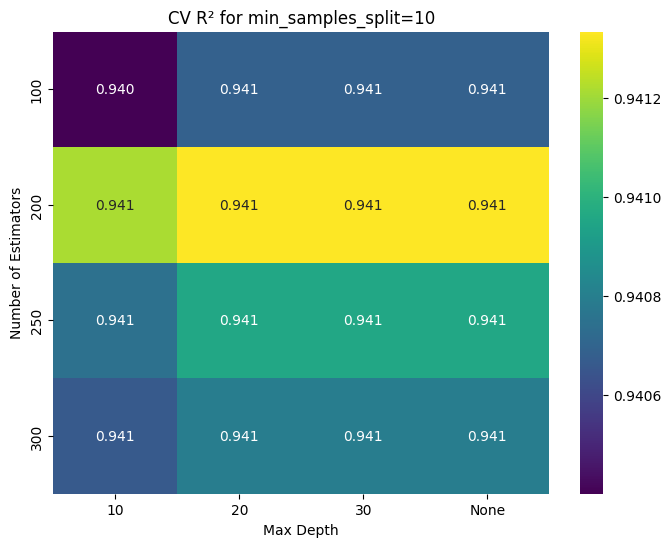

In [34]:
# Extract parameter ranges
n_estimators_vals = sorted(set(r['n_estimators'] for r in results))
max_depth_vals = sorted(set(r['max_depth'] for r in results), key=lambda x: (x is None, x))  # None goes last
min_samples_split_vals = sorted(set(r['min_samples_split'] for r in results))

# Plot heatmaps for each min_samples_split value
for mss in min_samples_split_vals:
    heatmap_data = np.zeros((len(n_estimators_vals), len(max_depth_vals)))
    
    for i, n_est in enumerate(n_estimators_vals):
        for j, max_d in enumerate(max_depth_vals):
            # find corresponding mean_r2
            for r in results:
                if (r['n_estimators'] == n_est and 
                    r['max_depth'] == max_d and 
                    r['min_samples_split'] == mss):
                    heatmap_data[i, j] = r['mean_r2']
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".3f",
        xticklabels=[str(x) for x in max_depth_vals],
        yticklabels=n_estimators_vals,
        cmap="viridis"
    )
    plt.title(f"CV R² for min_samples_split={mss}")
    plt.xlabel("Max Depth")
    plt.ylabel("Number of Estimators")
    plt.show()
